In [1]:
import keras,os
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split 
import warnings 
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")


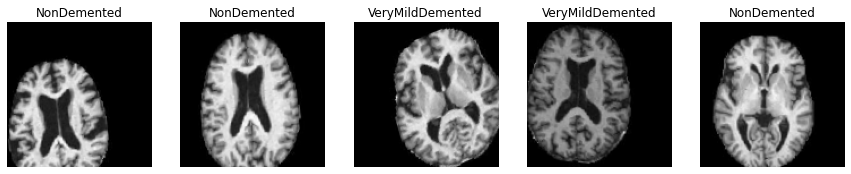

In [4]:
import matplotlib.pyplot as plt

sample_batch = next(train_dataset )

images, numerical_labels = sample_batch

class_indices = train_dataset .class_indices
class_names = list(class_indices.keys())
class_names = [class_names[num_label] for num_label in numerical_labels.argmax(axis=1)]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    axes[i].imshow(images[i])
    axes[i].set_title(class_names[i])
    axes[i].axis("off")

plt.show()

In [5]:
import os
from distutils.dir_util import copy_tree, remove_tree

base_dir = r"C:\Users\pothi\OneDrive\Desktop\DSIP\Dataset\Alzheimer_s Dataset"
root_dir = "./"
test_dir = os.path.join(base_dir, "test")
train_dir = os.path.join(base_dir, "train")
work_dir = os.path.join(root_dir, "dataset/")

if os.path.exists(work_dir):
    remove_tree(work_dir)

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [6]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

In [7]:
zoomrange = [.9, 1.0]
brightness = [0.7, 1.3]

work_dr = ImageDataGenerator(rescale = 1./255, brightness_range=brightness, zoom_range=zoomrange, 
                             data_format="channels_last", fill_mode="constant", horizontal_flip=True)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=(128,128), 
                                             batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [8]:
train_data_gen.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [9]:
train_data, train_labels = train_data_gen.next()

In [10]:
print(train_data.shape, train_labels.shape)

(6400, 128, 128, 3) (6400, 4)


In [11]:
valid_dataset = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)

Found 190 images belonging to 4 classes.


In [12]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 128 * 128 * 3), train_labels)
train_data = train_data.reshape(-1, 128, 128, 3)
print(train_data.shape, train_labels.shape)

(12800, 128, 128, 3) (12800, 4)


In [13]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.15, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [14]:
from keras.applications import InceptionV3
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [15]:
for layer in inception_model.layers:
    layer.trainable=False

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D,GlobalAveragePooling2D, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical

inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")


In [20]:
METRICS = [
        tf.keras.metrics.CategoricalAccuracy(name='acc')
]

inception_model.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

inception_model.summary()


Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 512)      

In [21]:
EPOCHS = 70
history = inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/70

272/272 [==============================] - 105s 353ms/step - loss: 1.5199 - acc: 0.3524 - val_loss: 0.9122 - val_acc: 0.5717
Epoch 2/70
272/272 [==============================] - 80s 295ms/step - loss: 1.0471 - acc: 0.5179 - val_loss: 0.7709 - val_acc: 0.6287
Epoch 3/70
272/272 [==============================] - 78s 289ms/step - loss: 0.9074 - acc: 0.5810 - val_loss: 0.7245 - val_acc: 0.6489
Epoch 4/70
272/272 [==============================] - 78s 285ms/step - loss: 0.8480 - acc: 0.6054 - val_loss: 0.6992 - val_acc: 0.6595
Epoch 5/70
272/272 [==============================] - 86s 317ms/step - loss: 0.8097 - acc: 0.6257 - val_loss: 0.6648 - val_acc: 0.6843
Epoch 6/70
272/272 [==============================] - 80s 296ms/step - loss: 0.7722 - acc: 0.6436 - val_loss: 0.6490 - val_acc: 0.6926
Epoch 7/70
272/272 [==============================] - 75s 275ms/step - loss: 0.7401 - acc: 0.6613 - val_loss: 0.6318 - val_acc: 0.7137
Epoch 8/70
272/272 [==============================] -

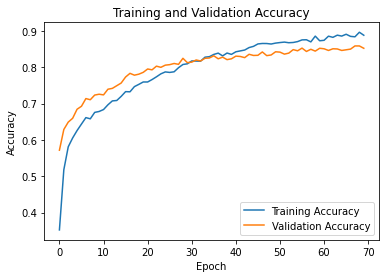

In [22]:
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

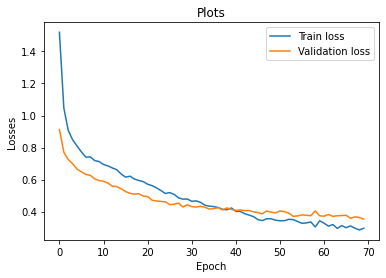

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Plots')
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.show()

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

predictions = inception_model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(test_labels, axis=1)

report = classification_report(true_classes, predicted_classes, target_names=CLASSES)
print(report)

60/60 [==============================] - 35s 451ms/step
                  precision    recall  f1-score   support

     NonDemented       0.92      0.86      0.89       474
VeryMildDemented       1.00      1.00      1.00       473
    MildDemented       0.76      0.80      0.78       507
ModerateDemented       0.72      0.72      0.72       466

        accuracy                           0.84      1920
       macro avg       0.85      0.84      0.85      1920
    weighted avg       0.85      0.84      0.84      1920



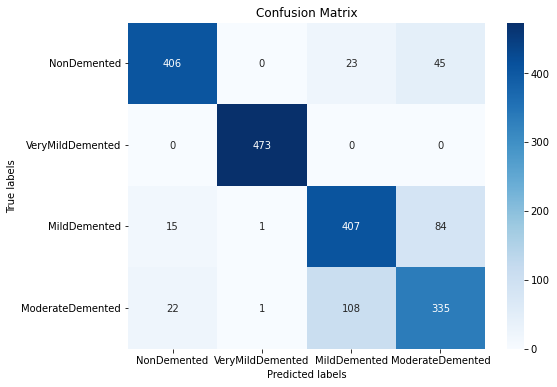

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Define the class labels
class_labels = CLASSES  # Assuming CLASSES is a list of class names

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [25]:
inception_model.save("INCEPTIONV3_ALZAIMERS_70.h5")

In [5]:
!pip install lime

     -------------------------------------- 275.7/275.7 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
datashader 0.13.0 requires numba>=0.51, which is not installed.
librosa 0.10.1 requires numba>=0.51.0, which is not installed.
tensorflow-intel 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.22.4 which is incompatible.



  Using cached numpy-1.22.4-cp39-cp39-win_amd64.whl.metadata (2.1 kB)
Using cached numpy-1.22.4-cp39-cp39-win_amd64.whl (14.7 MB)
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=e0ac76b798608a7e86ffddf33a0ff9fc6d2305e92eb866f5c3068f9cbcccb1df
  Stored in directory: c:\users\pothi\appdata\local\pip\cache\wheels\ed\d7\c9\5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


In [6]:
import keras
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
model = load_model('INCEPTIONV3_ALZAIMERS_70.h5')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 164ms/step


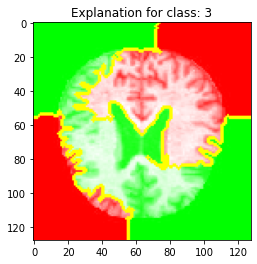

In [7]:
def preprocess_image(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.inception_v3.preprocess_input(img_array_expanded_dims)

image_path = r"D:\test\VeryMildDemented\27 (11).jpg"
preprocessed_img = preprocess_image(image_path)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(preprocessed_img[0].astype('double'), 
                                         model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('Explanation for class: {}'.format(explanation.top_labels[0]))
plt.show()

In [26]:
from tensorflow.keras.utils import img_to_array,load_img
def read_image(file_path):
    print("[INFO] loading and preprocessing image…") 
    image = load_img(file_path, target_size=(128,128,1)) 
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0) 
    return image

In [27]:
def predict_proba(number):
    return [number[0],1-number[0]]

In [31]:
import time
def test_single_image(path):
    labels = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = inception_model.predict(images) 
    preds = predict_proba(bt_prediction)
    for idx, label, x in zip(range(0,6), labels , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, label, np.round(x*100,2) ))
    
    return load_img(path)

In [46]:
path = r"D:\test\VeryMildDemented\27 (11).jpg"
test_single_image(path)

[INFO] loading and preprocessing image…
1/1 [==============================] - 0s 208ms/step
ID: 0, Label: MildDemented 0.0%
ID: 1, Label: ModerateDemented 0.0%
ID: 2, Label: NonDemented 0.0%
ID: 3, Label: VeryMildDemented 100.0%


In [37]:
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score,confusion_matrix

y_pred_probs = inception_model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1) 
y_true = np.argmax(test_labels, axis=1)

precision = precision_score(y_true, y_pred, average='macro') 
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")

60/60 [==============================] - 28s 463ms/step
Precision: 0.848, Recall: 0.845, F1-score: 0.846


In [66]:
inception_model.save("INCEPTIONV3_ALZAIMERS_40.h5")